
<a id='opt-tax-amss'></a>
<ul class="badges">
        <li><a href="#"><img src="/_static/img/jupyter-notebook-download-blue.svg" id="notebook_download_badge"></a></li>
        <li><a href="#"><img src="/_static/img/pdf-download-blue.svg" id="pdf_download_badge"></a></li>
        <li><a href="/status.html"><img src="https://img.shields.io/badge/Execution%20test-not%20available-lightgrey.svg" id="executability_status_badge"></a></li>
</ul>

<script>
var path = window.location.pathname;
var pageName = path.split("/").pop().split(".")[0];
var notebookDownloadLink = ["/", "_downloads/ipynb/jl/", pageName, ".ipynb"].join("");
document.getElementById('notebook_download_badge').parentElement.setAttribute('href', notebookDownloadLink);
var pdfDownloadLink = ["/", "_downloads/pdf/jl/", pageName, ".pdf"].join("");
document.getElementById('pdf_download_badge').parentElement.setAttribute('href', pdfDownloadLink);
</script>

<a href="/status.html"><img src="https://img.shields.io/badge/Execution%20test-not%20available-lightgrey.svg" id="executability_status_badge"></a>

<div class="how-to">
        <a href="#" class="toggle"><span class="icon icon-angle-double-down"></span>How to read this lecture...</a>
        <div class="how-to-content">
                <p>Code should execute sequentially if run in a Jupyter notebook</p>
                <ul>
                        <li>See the <a href="/jl/getting_started.html">set up page</a> to install Jupyter, Julia (1.0+) and all necessary libraries</li>
                        <li>Please direct feedback to <a href="mailto:contact@quantecon.org">contact@quantecon.org</a> or the <a href="http://discourse.quantecon.org/">discourse forum</a></li>
                        <li>For some notebooks, enable content with "Trust" on the command tab of Jupyter lab</li>
                        <li>If using QuantEcon lectures for the first time on a computer, execute <tt>] add InstantiateFromURL</tt> inside of a notebook or the REPL</li>
                </ul>
        </div>
</div>

# Optimal Taxation without State-Contingent Debt

## Contents

- [Optimal Taxation without State-Contingent Debt](#Optimal-Taxation-without-State-Contingent-Debt)  
  - [Overview](#Overview)  
  - [Competitive Equilibrium with Distorting Taxes](#Competitive-Equilibrium-with-Distorting-Taxes)  
  - [Recursive Version of AMSS Model](#Recursive-Version-of-AMSS-Model)  
  - [Examples](#Examples)  

## Overview

In [an earlier lecture](https://lectures.quantecon.org/jl/opt_tax_recur.html) we described a model of
optimal taxation with state-contingent debt due to
Robert E. Lucas, Jr.,  and Nancy Stokey  [[LS83]](https://lectures.quantecon.org/jl/zreferences.html#lucasstokey1983)

Aiyagari, Marcet, Sargent, and Seppälä [[AMSS02]](https://lectures.quantecon.org/jl/zreferences.html#amss-2002)  (hereafter, AMSS)
studied optimal taxation in a model without state-contingent debt

In this lecture, we

- describe assumptions and equilibrium concepts  
- solve the model  
- implement the model numerically  
- conduct some policy experiments  
- compare outcomes with those in a corresponding complete-markets model  


We begin with an introduction to the model

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.7");

In [2]:
using LinearAlgebra, Statistics, Compat

## Competitive Equilibrium with Distorting Taxes

Many but not all features of the economy are identical to those of [the Lucas-Stokey economy](https://lectures.quantecon.org/jl/opt_tax_recur.html)

Let’s start with things that are identical

For $ t \geq 0 $, a history of the state is represented by $ s^t = [s_t, s_{t-1}, \ldots, s_0] $

Government purchases $ g(s) $ are an exact time-invariant function of $ s $

Let $ c_t(s^t) $,  $ \ell_t(s^t) $, and $ n_t(s^t) $ denote consumption,
leisure, and labor supply, respectively, at history $ s^t $ at time $ t $

Each period a representative  household is endowed with one unit of time that can be divided between  leisure
$ \ell_t $ and labor $ n_t $:


<a id='equation-feas1-amss'></a>
$$
n_t(s^t) + \ell_t(s^t) = 1 \tag{1}
$$

Output equals $ n_t(s^t) $ and can be divided between consumption $ c_t(s^t) $ and $ g(s_t) $


<a id='equation-tss-techr-amss'></a>
$$
c_t(s^t) + g(s_t) = n_t(s^t) \tag{2}
$$

Output is not storable

The technology pins down a pre-tax wage rate to unity for all $ t, s^t $

A representative  household’s preferences over $ \{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty $ are ordered by


<a id='equation-ts-prefr-amss'></a>
$$
\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), \ell_t(s^t)] \tag{3}
$$

where

- $ \pi_t(s^t) $ is a joint probability distribution over the sequence $ s^t $, and  
- the utility function $ u $ is  increasing, strictly concave, and three times  continuously differentiable in both arguments  


The government imposes a flat rate tax $ \tau_t(s^t) $ on labor income at time $ t $, history $ s^t $

Lucas and Stokey assumed that there are complete markets in one-period Arrow securities; also see [smoothing models](https://lectures.quantecon.org/jl/smoothing.html)

It is at this point that AMSS [[AMSS02]](https://lectures.quantecon.org/jl/zreferences.html#amss-2002) modify the Lucas and Stokey economy

AMSS allow the government to issue only one-period risk-free debt each period

Ruling out complete markets in this way is a step in the direction of making total tax collections behave more like that prescribed in [[Bar79]](https://lectures.quantecon.org/jl/zreferences.html#barro1979) than they do in [[LS83]](https://lectures.quantecon.org/jl/zreferences.html#lucasstokey1983)

### Risk-free One-Period Debt Only

In period $ t $ and history $ s^t $, let

- $ b_{t+1}(s^t) $ be the amount of the time $ t+1 $ consumption good that at time $ t $ the government promised to pay  
- $ R_t(s^t) $ be the gross interest rate on  risk-free one-period debt between periods $ t $ and $ t+1 $  
- $ T_t(s^t) $ be a nonnegative lump-sum transfer to the representative household <sup><a href=#fn-a id=fn-a-link>[1]</a></sup>  


That $ b_{t+1}(s^t) $ is the same for all realizations of $ s_{t+1} $ captures its *risk-free* character

The market value at time $ t $ of government debt maturing at time $ t+1 $ equals $ b_{t+1}(s^t) $ divided by $ R_t(s^t) $.

The government’s budget constraint in period $ t $ at history $ s^t $ is


<a id='equation-ts-gov-wo'></a>
$$
\begin{aligned}
b_t(s^{t-1})
    & =    \tau^n_t(s^t) n_t(s^t) - g_t(s_t) - T_t(s^t) +
            {b_{t+1}(s^t) \over R_t(s^t )}
    \\
    & \equiv z(s^t) + {b_{t+1}(s^t) \over R_t(s^t )},
\end{aligned} \tag{4}
$$

where $ z(s^t) $ is the net-of-interest government surplus

To rule out Ponzi schemes, we assume that the government is subject to a **natural debt limit** (to be discussed in a forthcoming lecture)

The consumption Euler equation for a representative household able to trade only one-period risk-free debt
with one-period gross interest rate $ R_t(s^t) $ is

$$
{1 \over R_t(s^t)}
= \sum_{s^{t+1}\vert s^t} \beta  \pi_{t+1}(s^{t+1} | s^t)
                        { u_c(s^{t+1}) \over u_c(s^{t}) }
$$

Substituting this expression into the government’s budget constraint [(4)](#equation-ts-gov-wo)
yields:


<a id='equation-ts-gov-wo2'></a>
$$
b_t(s^{t-1}) =  z(s^t) + \beta  \sum_{s^{t+1}\vert s^t}  \pi_{t+1}(s^{t+1} | s^t)
                       { u_c(s^{t+1}) \over u_c(s^{t}) } \; b_{t+1}(s^t) \tag{5}
$$

Components of $ z(s^t) $ on the right side depend on $ s^t $, but the left side is required to depend on $ s^{t-1} $ only

**This is what it means for one-period government debt to be risk-free**

Therefore, the sum on the right side of equation [(5)](#equation-ts-gov-wo2) also has to depend only on $ s^{t-1} $

This requirement will give rise to **measurability constraints** on the Ramsey allocation to be discussed soon

If we replace $ b_{t+1}(s^t) $ on the right side of equation [(5)](#equation-ts-gov-wo2) by the right
side of next period’s budget constraint (associated with a
particular realization $ s_{t} $) we get

$$
b_t(s^{t-1}) =  z(s^t) + \sum_{s^{t+1}\vert s^t} \beta  \pi_{t+1}(s^{t+1} | s^t)
                       { u_c(s^{t+1}) \over u_c(s^{t}) }
\, \left[z(s^{t+1}) + {b_{t+2}(s^{t+1}) \over R_{t+1}(s^{t+1})}\right]
$$

After making similar repeated substitutions for all future occurrences of
government indebtedness, and by invoking the natural debt limit, we
arrive at:


<a id='equation-ts-gov-wo3'></a>
$$
\begin{aligned}
b_t(s^{t-1})
    &=  \sum_{j=0}^\infty \sum_{s^{t+j} | s^t} \beta^j  \pi_{t+j}(s^{t+j} | s^t)
              { u_c(s^{t+j}) \over u_c(s^{t}) } \;z(s^{t+j})
        \end{aligned} \tag{6}
$$

Now let’s

- substitute the resource constraint into the net-of-interest government surplus, and  
- use the household’s first-order condition $ 1-\tau^n_t(s^t)= u_{\ell}(s^t) /u_c(s^t) $ to eliminate the labor tax rate  


so that we can express the net-of-interest government surplus $ z(s^t) $ as


<a id='equation-amss-44-2'></a>
$$
z(s^t)
    = \left[1 - {u_{\ell}(s^t) \over u_c(s^t)}\right] \left[c_t(s^t)+g_t(s_t)\right]
        -g_t(s_t) - T_t(s^t)\,. \tag{7}
$$

If we substitute the  appropriate versions of right side of [(7)](#equation-amss-44-2) for $ z(s^{t+j}) $ into equation [(6)](#equation-ts-gov-wo3),
we obtain a sequence of *implementability constraints* on a Ramsey allocation in an AMSS economy

Expression [(6)](#equation-ts-gov-wo3) at time $ t=0 $ and initial state $ s^0 $
was also  an *implementability constraint* on a Ramsey allocation in a Lucas-Stokey economy:


<a id='equation-ts-gov-wo4'></a>
$$
b_0(s^{-1}) = \mathbb{E}\,_0 \sum_{j=0}^\infty \beta^j
               { u_c(s^{j}) \over u_c(s^{0}) } \;z(s^{j}) \tag{8}
$$

Indeed, it was the *only* implementability constraint there

But now we also have a large number of additional implementability constraints


<a id='equation-ts-gov-wo4a'></a>
$$
b_t(s^{t-1}) =  \mathbb{E}\,_t \sum_{j=0}^\infty \beta^j
              { u_c(s^{t+j}) \over u_c(s^{t}) } \;z(s^{t+j}) \tag{9}
$$

Equation [(9)](#equation-ts-gov-wo4a) must hold for each $ s^t $ for each $ t \geq 1 $

### Comparison with Lucas-Stokey Economy

The expression on the right side of [(9)](#equation-ts-gov-wo4a) in the Lucas-Stokey (1983) economy would  equal the present value of a continuation stream of government surpluses evaluated at what would be competitive equilibrium Arrow-Debreu prices at date $ t $

In the Lucas-Stokey economy, that present value is measurable with respect to $ s^t $

In the AMSS economy, the restriction that government debt be risk-free imposes that that same present value must be measurable with respect to $ s^{t-1} $

In a language used in the literature on incomplete markets models, it can be said that the AMSS model requires that at each $ (t, s^t) $ what would be the present value of continuation government surpluses in the Lucas-Stokey model must belong to  the **marketable subspace** of the AMSS model

### Ramsey Problem Without State-contingent Debt

After we have substituted the resource constraint into the utility function, we can express the Ramsey problem as being to choose an allocation that solves

$$
\max_{\{c_t(s^t),b_{t+1}(s^t)\}}
\mathbb{E}\,_0 \sum_{t=0}^\infty \beta^t
                        u\left(c_t(s^t),1-c_t(s^t)-g_t(s_t)\right)
$$

where the maximization is subject to


<a id='equation-amss-44'></a>
$$
\mathbb{E}\,_{0} \sum_{j=0}^\infty \beta^j
      { u_c(s^{j}) \over u_c(s^{0}) } \;z(s^{j}) \geq b_0(s^{-1}) \tag{10}
$$

and


<a id='equation-amss-46'></a>
$$
\mathbb{E}\,_{t} \sum_{j=0}^\infty \beta^j
    { u_c(s^{t+j}) \over u_c(s^{t}) } \;
    z(s^{t+j}) = b_t(s^{t-1})
      \quad \forall \,  s^t \tag{11}
$$

given $ b_0(s^{-1}) $

#### Lagrangian Formulation

Let $ \gamma_0(s^0) $ be a nonnegative Lagrange multiplier on constraint [(10)](#equation-amss-44)

As in the Lucas-Stokey economy, this multiplier is strictly positive when the government must resort to
distortionary taxation; otherwise it equals zero

A consequence of the assumption that there are no markets in state-contingent securities  and that a market exists only in a risk-free security is that we have to attach stochastic processes $ \{\gamma_t(s^t)\}_{t=1}^\infty $ of
Lagrange multipliers to the implementability constraints [(11)](#equation-amss-46)

Depending on how the constraints  bind, these multipliers can be positive or negative:

$$
\begin{aligned}
   \gamma_t(s^t)
   &\;\geq\; (\leq)\;\, 0 \quad \text{if the constraint binds in this direction }
   \\
   & \mathbb{E}\,_{t} \sum_{j=0}^\infty \beta^j
    { u_c(s^{t+j}) \over u_c(s^{t}) } \;z(s^{t+j}) \;\geq \;(\leq)\;\, b_t(s^{t-1}).
\end{aligned}
$$

A negative multiplier $ \gamma_t(s^t)<0 $ means that if we could
relax constraint [(11)](#equation-amss-46), we would like to *increase* the beginning-of-period
indebtedness for that particular realization of history $ s^t $

That would let us reduce the beginning-of-period indebtedness for some other history <sup><a href=#fn-b id=fn-b-link>[2]</a></sup>

These features flow from  the fact that the government cannot use state-contingent debt and therefore cannot allocate its indebtedness  efficiently across future states

### Some Calculations

It is helpful to apply two transformations to the Lagrangian

Multiply constraint [(10)](#equation-amss-44) by $ u_c(s^0) $ and the constraints [(11)](#equation-amss-46) by $ \beta^t u_c(s^{t}) $

Then a Lagrangian for the Ramsey problem can  be represented as


<a id='equation-amss-lagr-a'></a>
$$
\begin{aligned}
   J &= \mathbb{E}\,_{0} \sum_{t=0}^\infty \beta^t
                        \biggl\{ u\left(c_t(s^t), 1-c_t(s^t)-g_t(s_t)\right)\\
   &  \qquad + \gamma_t(s^t) \Bigl[ \mathbb{E}\,_{t} \sum_{j=0}^\infty \beta^j
         u_c(s^{t+j}) \,z(s^{t+j}) - u_c(s^{t}) \,b_t(s^{t-1}) \biggr\}
         \\
   &= \mathbb{E}\,_{0} \sum_{t=0}^\infty \beta^t
                         \biggl\{ u\left(c_t(s^t), 1-c_t(s^t)-g_t(s_t)\right)
        \\
   &  \qquad + \Psi_t(s^t)\, u_c(s^{t}) \,z(s^{t}) -
   \gamma_t(s^t)\, u_c(s^{t}) \, b_t(s^{t-1})  \biggr\}
\end{aligned} \tag{12}
$$

where


<a id='equation-amss-lagr'></a>
$$
\Psi_t(s^t)=\Psi_{t-1}(s^{t-1})+\gamma_t(s^t)
 \quad \text{and} \quad
\Psi_{-1}(s^{-1})=0 \tag{13}
$$

In [(12)](#equation-amss-lagr-a),  the second equality uses  the law of iterated expectations
and Abel’s summation formula (also called *summation by parts*, see
[this page](https://en.wikipedia.org/wiki/Abel%27s_summation_formula))

First-order conditions with respect
to $ c_t(s^t) $ can be expressed as


<a id='equation-amss-foc-a'></a>
$$
\begin{aligned}
  u_c(s^t)-u_{\ell}(s^t) &+ \Psi_t(s^t)\left\{ \left[
    u_{cc}(s^t) - u_{c\ell}(s^{t})\right]z(s^{t}) +
    u_{c}(s^{t})\,z_c(s^{t}) \right\}
    \\
    & \hspace{35mm} - \gamma_t(s^t)\left[
    u_{cc}(s^{t}) - u_{c\ell}(s^{t})\right]b_t(s^{t-1}) =0
\end{aligned} \tag{14}
$$

and with respect to $ b_t(s^t) $ as


<a id='equation-amss-foc-b'></a>
$$
\mathbb{E}\,_{t} \left[\gamma_{t+1}(s^{t+1})\,u_c(s^{t+1})\right] = 0 \tag{15}
$$

If we substitute $ z(s^t) $ from [(7)](#equation-amss-44-2) and its derivative
$ z_c(s^t) $ into first-order condition [(14)](#equation-amss-foc-a), we  find  two
differences from the corresponding condition for the optimal allocation
in a Lucas-Stokey economy with state-contingent government debt

1. The term involving $ b_t(s^{t-1}) $ in first-order condition
[(14)](#equation-amss-foc-a) does not appear in the corresponding expression
for the Lucas-Stokey economy

> - This term reflects the constraint that
  beginning-of-period government indebtedness must be the same across all
  realizations of next period’s state, a constraint that would  not be present if
  government debt could be state contingent  



2. The Lagrange multiplier $ \Psi_t(s^t) $ in first-order condition
[(14)](#equation-amss-foc-a) may change over time in response to realizations of the state,
while the multiplier $ \Phi $ in the Lucas-Stokey economy is time invariant

We need some code from our [an earlier lecture](https://lectures.quantecon.org/jl/opt_tax_recur.html)
on optimal taxation with state-contingent debt  sequential allocation implementation:

In [3]:
using QuantEcon, NLsolve, NLopt, Compat

import QuantEcon.simulate

mutable struct Model{TF <: AbstractFloat,
                    TM <: AbstractMatrix{TF},
                    TV <: AbstractVector{TF}}
    β::TF
    Π::TM
    G::TV
    Θ::TV
    transfers::Bool
    U::Function
    Uc::Function
    Ucc::Function
    Un::Function
    Unn::Function
    n_less_than_one::Bool
end


struct SequentialAllocation{TP <: Model,
                            TI <: Integer,
                            TV <: AbstractVector}
    model::TP
    mc::MarkovChain
    S::TI
    cFB::TV
    nFB::TV
    ΞFB::TV
    zFB::TV
end


function SequentialAllocation(model::Model)
    β, Π, G, Θ = model.β, model.Π, model.G, model.Θ
    mc = MarkovChain(Π)
    S = size(Π, 1)   # Number of states
    # Now find the first best allocation
    cFB, nFB, ΞFB, zFB = find_first_best(model, S, 1)

    return SequentialAllocation(model, mc, S, cFB, nFB, ΞFB, zFB)
end


function find_first_best(model::Model, S::Integer, version::Integer)
    if version != 1 && version != 2
        throw(ArgumentError("version must be 1 or 2"))
    end
    β, Θ, Uc, Un, G, Π =
        model.β, model.Θ, model.Uc, model.Un, model.G, model.Π
    function res!(out, z)
        c = z[1:S]
        n = z[S+1:end]
        out[1:S] = Θ .* Uc.(c, n) + Un.(c, n)
        out[S+1:end] = Θ .* n .- c .- G
    end
    res = nlsolve(res!, 0.5 * ones(2 * S))

    if converged(res) == false
        error("Could not find first best")
    end

    if version == 1
        cFB = res.zero[1:S]
        nFB = res.zero[S+1:end]
        ΞFB = Uc(cFB, nFB)         # Multiplier on the resource constraint
        zFB = vcat(cFB, nFB, ΞFB)
        return cFB, nFB, ΞFB, zFB
    elseif version == 2
        cFB = res.zero[1:S]
        nFB = res.zero[S+1:end]
        IFB = Uc(cFB, nFB) .* cFB + Un(cFB, nFB) .* nFB
        xFB = \(LinearAlgebra.I - β * Π, IFB)
        zFB = [vcat(cFB[s], xFB[s], xFB) for s in 1:S]
        return cFB, nFB, IFB, xFB, zFB
    end
end


function time1_allocation(pas::SequentialAllocation, μ::Real)
    model, S = pas.model, pas.S
    Θ, β, Π, G, Uc, Ucc, Un, Unn =
        model.Θ, model.β, model.Π, model.G,
        model.Uc, model.Ucc, model.Un, model.Unn
    function FOC!(out, z::Vector)
        c = z[1:S]
        n = z[S+1:2S]
        Ξ = z[2S+1:end]
        out[1:S] = Uc.(c, n) - μ * (Ucc.(c, n) .* c + Uc.(c, n)) - Ξ # FOC c
        out[S+1:2S] = Un.(c, n) - μ * (Unn(c, n) .* n .+ Un.(c, n)) + Θ .* Ξ # FOC n
        out[2S+1:end] = Θ .* n - c .- G # resource constraint
        return out
    end
    # Find the root of the FOC
    res = nlsolve(FOC!, pas.zFB)
    if res.f_converged == false
        error("Could not find LS allocation.")
    end
    z = res.zero
    c, n, Ξ = z[1:S], z[S+1:2S], z[2S+1:end]
    # Now compute x
    I  = Uc(c, n) .* c +  Un(c, n) .* n
    x = \(LinearAlgebra.I - β * model.Π, I)
    return c, n, x, Ξ
end


function time0_allocation(pas::SequentialAllocation,
                        B_::AbstractFloat, s_0::Integer)
    model = pas.model
    Π, Θ, G, β = model.Π, model.Θ, model.G, model.β
    Uc, Ucc, Un, Unn =
        model.Uc, model.Ucc, model.Un, model.Unn

    # First order conditions of planner's problem
    function FOC!(out, z)
        μ, c, n, Ξ = z[1], z[2], z[3], z[4]
        xprime = time1_allocation(pas, μ)[3]
        out .= vcat(
        Uc(c, n) .* (c - B_) + Un(c, n) .* n + β * dot(Π[s_0, :], xprime),
        Uc(c, n) .- μ * (Ucc(c, n) .* (c - B_) + Uc(c, n)) .- Ξ,
        Un(c, n) .- μ * (Unn(c, n) .* n + Un(c, n)) + Θ[s_0] .* Ξ,
        (Θ .* n .- c .- G)[s_0]
        )
    end

    # Find root
    res = nlsolve(FOC!, [0.0, pas.cFB[s_0], pas.nFB[s_0], pas.ΞFB[s_0]])
    if res.f_converged == false
        error("Could not find time 0 LS allocation.")
    end
    return (res.zero...,)
end


function time1_value(pas::SequentialAllocation, μ::Real)
    model = pas.model
    c, n, x, Ξ = time1_allocation(pas, μ)
    U_val = model.U.(c, n)
    V = \(LinearAlgebra.I - model.β*model.Π, U_val)
    return c, n, x, V
end


function Τ(model::Model, c::Union{Real,Vector}, n::Union{Real,Vector})
    Uc, Un = model.Uc.(c, n), model.Un.(c, n)
    return 1. .+ Un./(model.Θ .* Uc)
end


function simulate(pas::SequentialAllocation,
                B_::AbstractFloat, s_0::Integer,
                T::Integer,
                sHist::Union{Vector, Nothing}=nothing)

    model = pas.model
    Π, β, Uc = model.Π, model.β, model.Uc

    if sHist === nothing
        sHist = QuantEcon.simulate(pas.mc, T, init=s_0)
    end
    cHist = zeros(T)
    nHist = zeros(T)
    Bhist = zeros(T)
    ΤHist = zeros(T)
    μHist = zeros(T)
    RHist = zeros(T-1)
    # time 0
    μ, cHist[1], nHist[1], _  = time0_allocation(pas, B_, s_0)
    ΤHist[1] = Τ(pas.model, cHist[1], nHist[1])[s_0]
    Bhist[1] = B_
    μHist[1] = μ
    # time 1 onward
    for t in 2:T
        c, n, x, Ξ = time1_allocation(pas,μ)
        u_c = Uc(c,n)
        s = sHist[t]
        ΤHist[t] = Τ(pas.model, c, n)[s]
        Eu_c = dot(Π[sHist[t-1],:], u_c)
        cHist[t], nHist[t], Bhist[t] = c[s], n[s], x[s] / u_c[s]
        RHist[t-1] = Uc(cHist[t-1], nHist[t-1]) / (β * Eu_c)
        μHist[t] = μ
    end
    return cHist, nHist, Bhist, ΤHist, sHist, μHist, RHist
end


mutable struct BellmanEquation{TP <: Model,
                            TI <: Integer,
                            TV <: AbstractVector,
                            TM <: AbstractMatrix{TV},
                            TVV <: AbstractVector{TV}}
    model::TP
    S::TI
    xbar::TV
    time_0::Bool
    z0::TM
    cFB::TV
    nFB::TV
    xFB::TV
    zFB::TVV
end


function BellmanEquation(model::Model, xgrid::AbstractVector, policies0::Vector)
    S = size(model.Π, 1) # number of states
    xbar = [minimum(xgrid), maximum(xgrid)]
    time_0 = false
    cf, nf, xprimef = policies0
    z0 = [vcat(cf[s](x), nf[s](x), [xprimef[s, sprime](x) for sprime in 1:S])
                        for x in xgrid, s in 1:S]
    cFB, nFB, IFB, xFB, zFB = find_first_best(model, S, 2)
    return BellmanEquation(model, S, xbar, time_0, z0, cFB, nFB, xFB, zFB)
end


function get_policies_time1(T::BellmanEquation,
                        i_x::Integer, x::AbstractFloat,
                        s::Integer, Vf::AbstractArray)
    model, S = T.model, T.S
    β, Θ, G, Π = model.β, model.Θ, model.G, model.Π
    U, Uc, Un = model.U, model.Uc, model.Un

    function objf(z::Vector, grad)
        c, xprime = z[1], z[2:end]
        n=c+G[s]
        Vprime = [Vf[sprime](xprime[sprime]) for sprime in 1:S]
        return -(U(c, n) + β * dot(Π[s, :], Vprime))
    end
    function cons(z::Vector, grad)
        c, xprime = z[1], z[2:end]
        n=c+G[s]
        return x - Uc(c, n) * c - Un(c, n) * n - β * dot(Π[s, :], xprime)
    end
    lb = vcat(0, T.xbar[1] * ones(S))
    ub = vcat(1 - G[s], T.xbar[2] * ones(S))
    opt = Opt(:LN_COBYLA, length(T.z0[i_x, s])-1)
    min_objective!(opt, objf)
    equality_constraint!(opt, cons)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 300)
    maxtime!(opt, 10)
    init = vcat(T.z0[i_x, s][1], T.z0[i_x, s][3:end])
    for (i, val) in enumerate(init)
        if val > ub[i]
            init[i] = ub[i]
        elseif val < lb[i]
            init[i] = lb[i]
        end
    end
    (minf, minx, ret) = optimize(opt, init)
    T.z0[i_x, s] = vcat(minx[1], minx[1] + G[s], minx[2:end])
    return vcat(-minf, T.z0[i_x, s])
end

function get_policies_time0(T::BellmanEquation,
                        B_::AbstractFloat, s0::Integer, Vf::Array)
    model, S = T.model, T.S
    β, Θ, G, Π = model.β, model.Θ, model.G, model.Π
    U, Uc, Un = model.U, model.Uc, model.Un
    function objf(z, grad)
        c, xprime = z[1], z[2:end]
        n = c+G[s0]
        Vprime = [Vf[sprime](xprime[sprime]) for sprime in 1:S]
        return -(U(c, n) + β * dot(Π[s0, :], Vprime))
    end
    function cons(z::Vector, grad)
        c, xprime = z[1], z[2:end]
        n = c + G[s0]
        return -Uc(c, n) * (c - B_) - Un(c, n) * n - β * dot(Π[s0, :], xprime)
    end
    lb = vcat(0, T.xbar[1] * ones(S))
    ub = vcat(1-G[s0], T.xbar[2] * ones(S))
    opt = Opt(:LN_COBYLA, length(T.zFB[s0])-1)
    min_objective!(opt, objf)
    equality_constraint!(opt, cons)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 300)
    maxtime!(opt, 10)
    init = vcat(T.zFB[s0][1], T.zFB[s0][3:end])
    for (i, val) in enumerate(init)
        if val > ub[i]
            init[i] = ub[i]
        elseif val < lb[i]
            init[i] = lb[i]
        end
    end
    (minf, minx, ret) = optimize(opt, init)
    return vcat(-minf, vcat(minx[1], minx[1]+G[s0], minx[2:end]))
end

get_policies_time0 (generic function with 1 method)

To analyze the AMSS model, we find it useful to adopt a recursive formulation
using techniques like those in our lectures on [dynamic Stackelberg models](https://lectures.quantecon.org/jl/dyn_stack.html) and [optimal taxation with state-contingent debt](https://lectures.quantecon.org/jl/opt_tax_recur.html)

## Recursive Version of AMSS Model

We now describe a recursive formulation of the AMSS economy

We have noted that from the point of view of the Ramsey planner, the restriction
to one-period risk-free securities

- leaves intact the single implementability constraint on allocations
  [(8)](#equation-ts-gov-wo4) from the Lucas-Stokey economy, but  
- adds measurability constraints [(6)](#equation-ts-gov-wo3) on functions of tails of
  allocations at each time and history  


We now explore how these constraints alter  Bellman equations for a time
$ 0 $ Ramsey planner and for time $ t \geq 1 $, history $ s^t $
continuation Ramsey planners

### Recasting State Variables

In the AMSS setting, the government faces a sequence of budget constraints

$$
\tau_t(s^t) n_t(s^t) + T_t(s^t) +  b_{t+1}(s^t)/ R_t (s^t) =  g_t + b_t(s^{t-1})
$$

where $ R_t(s^t) $ is the gross risk-free rate of interest between $ t $
and $ t+1 $ at history $ s^t $ and $ T_t(s^t) $ are nonnegative transfers

Throughout this lecture, we shall set transfers to zero (for some issues about the limiting behavior of debt, this makes a possibly
important difference from AMSS [[AMSS02]](https://lectures.quantecon.org/jl/zreferences.html#amss-2002), who restricted transfers
to be nonnegative)

In this case, the household faces a sequence of budget constraints


<a id='equation-eqn-amssapp1'></a>
$$
b_t(s^{t-1}) + (1-\tau_t(s^t)) n_t(s^t) = c_t(s^t) + b_{t+1}(s^t)/R_t(s^t) \tag{16}
$$

The household’s first-order conditions are $ u_{c,t} = \beta R_t \mathbb{E}\,_t u_{c,t+1} $
and $ (1-\tau_t) u_{c,t} = u_{l,t} $

Using these to eliminate $ R_t $ and $ \tau_t $ from  budget constraint
[(16)](#equation-eqn-amssapp1) gives


<a id='equation-eqn-amssapp2a'></a>
$$
b_t(s^{t-1}) + \frac{u_{l,t}(s^t)}{u_{c,t}(s^t)} n_t(s^t)
= c_t(s^t) + {\frac{\beta (\mathbb{E}\,_t u_{c,t+1}) b_{t+1}(s^t)}{u_{c,t}(s^t)}} \tag{17}
$$

or


<a id='equation-eqn-amssapp2'></a>
$$
u_{c,t}(s^t) b_t(s^{t-1}) + u_{l,t}(s^t) n_t(s^t)
= u_{c,t}(s^t) c_t(s^t) + \beta (\mathbb{E}\,_t u_{c,t+1}) b_{t+1}(s^t) \tag{18}
$$

Now define


<a id='equation-eqn-amssapp3'></a>
$$
x_t \equiv \beta b_{t+1}(s^t) \mathbb{E}\,_t u_{c,t+1} = u_{c,t} (s^t) {\frac{b_{t+1}(s^t)}{R_t(s^t)}} \tag{19}
$$

and represent the household’s budget constraint at time $ t $,
history $ s^t $ as


<a id='equation-eqn-amssapp4'></a>
$$
{\frac{u_{c,t} x_{t-1}}{\beta \mathbb{E}\,_{t-1} u_{c,t}}} = u_{c,t} c_t - u_{l,t} n_t + x_t \tag{20}
$$

for $ t \geq 1 $

### Measurability Constraints

Write equation [(18)](#equation-eqn-amssapp2) as


<a id='equation-eqn-amssapp2b'></a>
$$
b_t(s^{t-1})  = c_t(s^t) -  { \frac{u_{l,t}(s^t)}{u_{c,t}(s^t)}} n_t(s^t) +
{\frac{\beta (\mathbb{E}\,_t u_{c,t+1}) b_{t+1}(s^t)}{u_{c,t}}} \tag{21}
$$

The right side of equation [(21)](#equation-eqn-amssapp2b) expresses the time $ t $ value of government debt
in terms of a linear combination of terms whose individual components
are measurable with respect to $ s^t $

The sum  of terms on the right side  of equation [(21)](#equation-eqn-amssapp2b) must equal
$ b_t(s^{t-1}) $

That implies that it is has to be *measurable* with respect to $ s^{t-1} $

Equations [(21)](#equation-eqn-amssapp2b) are the *measurablility constraints* that the AMSS model adds to the single time $ 0 $ implementation
constraint imposed in the Lucas and Stokey model

### Two Bellman Equations

Let $ \Pi(s|s_-) $ be a Markov transition matrix whose entries tell probabilities of moving from state $ s_- $ to state $ s $ in one period

Let

- $ V(x_-, s_-) $ be the continuation value of a continuation
  Ramsey plan at $ x_{t-1} = x_-, s_{t-1} =s_- $ for $ t \geq 1 $  
- $ W(b, s) $ be the value of the Ramsey plan at time $ 0 $ at
  $ b_0=b $ and $ s_0 = s $  


We distinguish between two types of planners:

For $ t \geq 1 $, the value function for a **continuation Ramsey planner**
satisfies the Bellman equation


<a id='equation-eqn-amssapp5'></a>
$$
V(x_-,s_-) = \max_{\{n(s), x(s)\}} \sum_s \Pi(s|s_-) \left[ u(n(s) -
g(s), 1-n(s)) + \beta V(x(s),s) \right] \tag{22}
$$

subject to the following collection of implementability constraints, one
for each $ s \in {\cal S} $:


<a id='equation-eqn-amssapp6'></a>
$$
{\frac{u_c(s) x_- }{\beta \sum_{\tilde s} \Pi(\tilde s|s_-) u_c(\tilde s) }}
= u_c(s) (n(s) - g(s)) - u_l(s) n(s) + x(s) \tag{23}
$$

A continuation Ramsey planner at $ t \geq 1 $ takes
$ (x_{t-1}, s_{t-1}) = (x_-, s_-) $ as given and before
$ s $ is realized chooses
$ (n_t(s_t), x_t(s_t)) = (n(s), x(s)) $ for $ s \in  {\cal S} $

The **Ramsey planner** takes $ (b_0, s_0) $ as given and chooses $ (n_0, x_0) $.

The value function $ W(b_0, s_0) $   for the time $ t=0 $ Ramsey planner
satisfies the Bellman equation


<a id='equation-eqn-amssapp100'></a>
$$
W(b_0, s_0) = \max_{n_0, x_0} u(n_0 - g_0, 1-n_0) + \beta V(x_0,s_0) \tag{24}
$$

where maximization is subject to


<a id='equation-eqn-ammssapp101'></a>
$$
u_{c,0} b_0 = u_{c,0} (n_0-g_0) - u_{l,0} n_0 + x_0 \tag{25}
$$

### Martingale Supercedes State-Variable Degeneracy

Let $ \mu(s|s_-) \Pi(s|s_-) $ be a Lagrange multiplier on constraint [(23)](#equation-eqn-amssapp6)
for state $ s $

After forming an appropriate Lagrangian, we find that the continuation Ramsey planner’s first-order
condition with respect to $ x(s) $ is


<a id='equation-eqn-amssapp7'></a>
$$
\beta V_x(x(s),s) = \mu(s|s_-) \tag{26}
$$

Applying the envelope theorem to Bellman equation [(22)](#equation-eqn-amssapp5) gives


<a id='equation-eqn-amssapp8'></a>
$$
V_x(x_-,s_-) = \sum_s \Pi(s|s_-) \mu(s|s_-) {\frac{u_c(s)}{\beta \sum_{\tilde s}
\Pi(\tilde s|s_-) u_c(\tilde s) }} \tag{27}
$$

Equations [(26)](#equation-eqn-amssapp7) and [(27)](#equation-eqn-amssapp8) imply that


<a id='equation-eqn-amssapp9'></a>
$$
V_x(x_-, s_-) = \sum_{s} \left( \Pi(s|s_-) {\frac{u_c(s)}{\sum_{\tilde s}
\Pi(\tilde s| s_-) u_c(\tilde s)}} \right) V_x(x(s), s) \tag{28}
$$

Equation [(28)](#equation-eqn-amssapp9) states that $ V_x(x, s) $ is a *risk-adjusted martingale*

Saying that $ V_x(x, s) $ is a risk-adjusted martingale  means  that
$ V_x(x, s) $  is a martingale with respect to the probability distribution
over $ s^t $ sequences that is generated by the *twisted* transition probability matrix:

$$
\check \Pi(s|s_-) \equiv \Pi(s|s_-) {\frac{u_c(s)}{\sum_{\tilde s}
\Pi(\tilde s| s_-) u_c(\tilde s)}}
$$

**Exercise**: Please verify that $ \check \Pi(s|s_-) $ is a valid Markov
transition density, i.e., that its elements are all nonnegative and
that for each $ s_- $, the sum over $ s $ equals unity

### Absence of State Variable Degeneracy

Along a Ramsey plan, the state variable $ x_t = x_t(s^t, b_0) $
becomes a function of the history $ s^t $ and initial
government debt $ b_0 $

In [Lucas-Stokey model](https://lectures.quantecon.org/jl/opt_tax_recur.html), we
found that

- a counterpart to $ V_x(x,s) $ is time invariant and equal to
  the Lagrange multiplier on the Lucas-Stokey implementability constraint  
- time invariance of $ V_x(x,s) $  is the source of a key
  feature of the Lucas-Stokey model, namely, state variable degeneracy
  (i.e., $ x_t $ is an exact function of $ s_t $)  


That $ V_x(x,s) $ varies over time according to a twisted martingale
means that there is no state-variable degeneracy in the AMSS model

In the AMSS model, both $ x $ and $ s $ are needed to describe the state

This property of the AMSS model  transmits a twisted martingale
component to consumption, employment, and the tax rate

### Digression on Nonnegative Transfers

Throughout this lecture we have imposed that transfers $ T_t = 0 $

AMSS [[AMSS02]](https://lectures.quantecon.org/jl/zreferences.html#amss-2002) instead imposed a nonnegativity
constraint $ T_t\geq 0 $ on transfers

They also considered a special case of quasi-linear preferences,
$ u(c,l)= c + H(l) $

In this case, $ V_x(x,s)\leq 0 $ is a non-positive martingale

By the *martingale convergence theorem*  $ V_x(x,s) $ converges almost surely

Furthermore, when the Markov chain $ \Pi(s| s_-) $ and the government
expenditure function $ g(s) $ are such that $ g_t $ is perpetually
random, $ V_x(x, s) $ almost surely converges to zero

For quasi-linear preferences, the first-order condition with respect to $ n(s) $ becomes

$$
(1-\mu(s|s_-) ) (1 - u_l(s)) + \mu(s|s_-) n(s) u_{ll}(s) =0
$$

When $ \mu(s|s_-) = \beta V_x(x(s),x) $ converges to zero, in the limit
$ u_l(s)= 1 =u_c(s) $, so that $ \tau(x(s),s) =0 $

Thus, in the limit, if $ g_t $ is perpetually random,  the government
accumulates sufficient assets to finance all expenditures from earnings on those
assets, returning any excess revenues to the household as nonnegative lump sum transfers

### Code

The recursive formulation is implemented as follows

In [4]:
using Dierckx


mutable struct BellmanEquation_Recursive{TP <: Model, TI <: Integer, TR <: Real}
    model::TP
    S::TI
    xbar::Array{TR}
    time_0::Bool
    z0::Array{Array}
    cFB::Vector{TR}
    nFB::Vector{TR}
    xFB::Vector{TR}
    zFB::Vector{Vector{TR}}
end


struct RecursiveAllocation{TP <: Model,
                        TI <: Integer,
                        TVg <: AbstractVector,
                        TT <: Tuple}
    model::TP
    mc::MarkovChain
    S::TI
    T::BellmanEquation_Recursive
    μgrid::TVg
    xgrid::TVg
    Vf::Array
    policies::TT
end


function RecursiveAllocation(model::Model, μgrid::AbstractArray)
    G = model.G
    S = size(model.Π, 1)             # number of states
    mc = MarkovChain(model.Π)
    # now find the first best allocation
    Vf, policies, T, xgrid = solve_time1_bellman(model, μgrid)
    T.time_0 = true                  # Bellman equation now solves time 0 problem
    return RecursiveAllocation(model, mc, S, T, μgrid, xgrid, Vf, policies)
end


function solve_time1_bellman(model::Model{TR}, μgrid::AbstractArray) where {TR <: Real}
    Π = model.Π
    S = size(model.Π, 1)

    # First get initial fit from lucas stockey solution.
    # Need to change things to be ex_ante
    PP = SequentialAllocation(model)

    function incomplete_allocation(PP::SequentialAllocation,
                                μ_::AbstractFloat,
                                s_::Integer)
        c, n, x, V = time1_value(PP, μ_)
        return c, n, dot(Π[s_, :], x), dot(Π[s_, :], V)
    end

    cf = Array{Function}(undef, S, S)
    nf = Array{Function}(undef, S, S)
    xprimef = Array{Function}(undef, S, S)
    Vf = Vector{Function}(undef, S)
    xgrid = Array{TR}(undef, S, length(μgrid))

    for s_ in 1:S
        c = Array{TR}(undef, length(μgrid), S)
        n = Array{TR}(undef, length(μgrid), S)
        x = Array{TR}(undef, length(μgrid))
        V = Array{TR}(undef, length(μgrid))
        for (i_μ, μ) in enumerate(μgrid)
            c[i_μ, :], n[i_μ, :], x[i_μ], V[i_μ] =
                incomplete_allocation(PP, μ, s_)
        end
        xprimes = repeat(x, 1, S)
        xgrid[s_, :] = x
        for sprime = 1:S
            splc = Spline1D(x[end:-1:1], c[:, sprime][end:-1:1], k=3)
            spln = Spline1D(x[end:-1:1], n[:, sprime][end:-1:1], k=3)
            splx = Spline1D(x[end:-1:1], xprimes[:, sprime][end:-1:1], k=3)
            cf[s_, sprime] = y -> splc(y)
            nf[s_, sprime] = y -> spln(y)
            xprimef[s_, sprime] = y -> splx(y)
            # cf[s_, sprime] = LinInterp(x[end:-1:1], c[:, sprime][end:-1:1])
            # nf[s_, sprime] = LinInterp(x[end:-1:1], n[:, sprime][end:-1:1])
            # xprimef[s_, sprime] = LinInterp(x[end:-1:1], xprimes[:, sprime][end:-1:1])
        end
        splV = Spline1D(x[end:-1:1], V[end:-1:1], k=3)
        Vf[s_] = y -> splV(y)
        # Vf[s_] = LinInterp(x[end:-1:1], V[end:-1:1])
    end

    policies = [cf, nf, xprimef]

    # Create xgrid
    xbar = [maximum(minimum(xgrid)), minimum(maximum(xgrid))]
    xgrid = range(xbar[1], xbar[2], length = length(μgrid))

    # Now iterate on Bellman equation
    T = BellmanEquation_Recursive(model, xgrid, policies)
    diff = 1.0
    while diff > 1e-4
        PF = (i_x, x, s) -> get_policies_time1(T, i_x, x, s, Vf, xbar)
        Vfnew, policies = fit_policy_function(T, PF, xgrid)

        diff = 0.0
        for s=1:S
            diff = max(diff, maximum(abs, (Vf[s].(xgrid) - Vfnew[s].(xgrid)) ./
                                            Vf[s].(xgrid)))
        end

        println("diff = $diff")
        Vf = copy(Vfnew)
    end

    return Vf, policies, T, xgrid
end


function fit_policy_function(T::BellmanEquation_Recursive,
                             PF::Function,
                             xgrid::AbstractVector{TF}) where {TF <: AbstractFloat}
    S = T.S
    # preallocation
    PFvec = Array{TF}(undef, 4S + 1, length(xgrid))
    cf = Array{Function}(undef, S, S)
    nf = Array{Function}(undef, S, S)
    xprimef = Array{Function}(undef, S, S)
    TTf = Array{Function}(undef, S, S)
    Vf = Vector{Function}(undef, S)
    # fit policy fuctions
    for s_ in 1:S
        for (i_x, x) in enumerate(xgrid)
            PFvec[:, i_x] = PF(i_x, x, s_)
        end
        splV = Spline1D(xgrid, PFvec[1,:], k=3)
        Vf[s_] = y -> splV(y)
        # Vf[s_] = LinInterp(xgrid, PFvec[1, :])
        for sprime=1:S
            splc = Spline1D(xgrid, PFvec[1 + sprime, :], k=3)
            spln = Spline1D(xgrid, PFvec[1 + S + sprime, :], k=3)
            splxprime = Spline1D(xgrid, PFvec[1 + 2S + sprime, :], k=3)
            splTT = Spline1D(xgrid, PFvec[1 + 3S + sprime, :], k=3)
            cf[s_, sprime] = y -> splc(y)
            nf[s_, sprime] = y -> spln(y)
            xprimef[s_, sprime] = y -> splxprime(y)
            TTf[s_, sprime] = y -> splTT(y)
        end
    end
    policies = (cf, nf, xprimef, TTf)
    return Vf, policies
end


function Tau(pab::RecursiveAllocation,
            c::AbstractArray,
        n::AbstractArray)
    model = pab.model
    Uc, Un = model.Uc(c, n), model.Un(c, n)
    return 1. .+ Un ./ (model.Θ .* Uc)
end

Tau(pab::RecursiveAllocation, c::Real, n::Real) = Tau(pab, [c], [n])


function time0_allocation(pab::RecursiveAllocation, B_::Real, s0::Integer)
    T, Vf = pab.T, pab.Vf
    xbar = T.xbar
    z0 = get_policies_time0(T, B_, s0, Vf, xbar)

    c0, n0, xprime0, T0 = z0[2], z0[3], z0[4], z0[5]
    return c0, n0, xprime0, T0
end


function simulate(pab::RecursiveAllocation,
                  B_::TF, s_0::Integer, T::Integer,
                  sHist::Vector=simulate(pab.mc, T, init=s_0)) where {TF <: AbstractFloat}
    model, mc, Vf, S = pab.model, pab.mc, pab.Vf, pab.S
    Π, Uc = model.Π, model.Uc
    cf, nf, xprimef, TTf = pab.policies

    cHist = Array{TF}(undef, T)
    nHist = Array{TF}(undef, T)
    Bhist = Array{TF}(undef, T)
    xHist = Array{TF}(undef, T)
    TauHist = Array{TF}(undef, T)
    THist = Array{TF}(undef, T)
    μHist = Array{TF}(undef, T)

    #time0
    cHist[1], nHist[1], xHist[1], THist[1]  = time0_allocation(pab, B_, s_0)
    TauHist[1] = Tau(pab, cHist[1], nHist[1])[s_0]
    Bhist[1] = B_
    μHist[1] = Vf[s_0](xHist[1])

    #time 1 onward
    for t in 2:T
        s_, x, s = sHist[t-1], xHist[t-1], sHist[t]
        c = Array{TF}(undef, S)
        n = Array{TF}(undef, S)
        xprime = Array{TF}(undef, S)
        TT = Array{TF}(undef, S)
        for sprime=1:S
            c[sprime], n[sprime], xprime[sprime], TT[sprime] =
                cf[s_, sprime](x), nf[s_, sprime](x),
                xprimef[s_, sprime](x), TTf[s_, sprime](x)
        end

        Tau_val = Tau(pab, c, n)[s]
        u_c = Uc(c, n)
        Eu_c = dot(Π[s_, :], u_c)

        μHist[t] = Vf[s](xprime[s])

        cHist[t], nHist[t], Bhist[t], TauHist[t] = c[s], n[s], x/Eu_c, Tau_val
        xHist[t], THist[t] = xprime[s], TT[s]
    end
    return cHist, nHist, Bhist, xHist, TauHist, THist, μHist, sHist
end


function BellmanEquation_Recursive(model::Model{TF},
                                   xgrid::AbstractVector{TF},
                                   policies0::Array) where {TF <: AbstractFloat}

    S = size(model.Π, 1) # number of states
    xbar = [minimum(xgrid), maximum(xgrid)]
    time_0 = false
    z0 = Array{Array}(undef, length(xgrid), S)
    cf, nf, xprimef = policies0[1], policies0[2], policies0[3]
    for s in 1:S
        for (i_x, x) in enumerate(xgrid)
            cs = Array{TF}(undef, S)
            ns = Array{TF}(undef, S)
            xprimes = Array{TF}(undef, S)
            for j = 1:S
                cs[j], ns[j], xprimes[j] = cf[s, j](x), nf[s, j](x), xprimef[s, j](x)
            end
            z0[i_x, s] = vcat(cs, ns, xprimes, zeros(S))
        end
    end
    cFB, nFB, IFB, xFB, zFB = find_first_best(model, S, 2)
    return BellmanEquation_Recursive(model, S, xbar, time_0, z0, cFB, nFB, xFB, zFB)
end



function get_policies_time1(T::BellmanEquation_Recursive,
                            i_x::Integer,
                            x::Real,
                            s_::Integer,
                            Vf::AbstractArray{Function},
                            xbar::AbstractVector)
    model, S = T.model, T.S
    β, Θ, G, Π = model.β, model.Θ, model.G, model.Π
    U,Uc,Un = model.U, model.Uc, model.Un

    S_possible = sum(Π[s_, :].>0)
    sprimei_possible = findall(Π[s_, :].>0)

    function objf(z, grad)
        c, xprime = z[1:S_possible], z[S_possible+1:2S_possible]
        n = (c .+ G[sprimei_possible]) ./ Θ[sprimei_possible]
        Vprime = [Vf[sprimei_possible[si]](xprime[si]) for si in 1:S_possible]
        return -dot(Π[s_, sprimei_possible], U.(c, n) + β * Vprime)
    end

    function cons(out, z, grad)
        c, xprime, TT =
            z[1:S_possible], z[S_possible + 1:2S_possible], z[2S_possible + 1:3S_possible]
        n = (c .+ G[sprimei_possible]) ./ Θ[sprimei_possible]
        u_c = Uc.(c, n)
        Eu_c = dot(Π[s_, sprimei_possible], u_c)
        out .= x * u_c/Eu_c - u_c .* (c - TT) - Un(c, n) .* n - β * xprime
    end
    function cons_no_trans(out, z, grad)
        c, xprime = z[1:S_possible], z[S_possible + 1:2S_possible]
        n = (c .+ G[sprimei_possible]) ./ Θ[sprimei_possible]
        u_c = Uc.(c, n)
        Eu_c = dot(Π[s_, sprimei_possible], u_c)
        out .= x * u_c / Eu_c - u_c .* c - Un(c, n) .* n - β * xprime
    end

    if model.transfers == true
        lb = vcat(zeros(S_possible), ones(S_possible)*xbar[1], zeros(S_possible))
        if model.n_less_than_one == true
            ub = vcat(ones(S_possible) - G[sprimei_possible],
                    ones(S_possible) * xbar[2], ones(S_possible))
        else
            ub = vcat(100 * ones(S_possible),
                    ones(S_possible) * xbar[2],
                    100 * ones(S_possible))
        end
        init = vcat(T.z0[i_x, s_][sprimei_possible],
                    T.z0[i_x, s_][2S .+ sprimei_possible],
                    T.z0[i_x, s_][3S .+ sprimei_possible])
        opt = Opt(:LN_COBYLA, 3S_possible)
        equality_constraint!(opt, cons, zeros(S_possible))
    else
        lb = vcat(zeros(S_possible), ones(S_possible)*xbar[1])
        if model.n_less_than_one == true
            ub = vcat(ones(S_possible)-G[sprimei_possible], ones(S_possible)*xbar[2])
        else
            ub = vcat(ones(S_possible), ones(S_possible) * xbar[2])
        end
        init = vcat(T.z0[i_x, s_][sprimei_possible],
                    T.z0[i_x, s_][2S .+ sprimei_possible])
        opt = Opt(:LN_COBYLA, 2S_possible)
        equality_constraint!(opt, cons_no_trans, zeros(S_possible))
    end
    init[init .> ub] = ub[init .> ub]
    init[init .< lb] = lb[init .< lb]

    min_objective!(opt, objf)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 10000000)
    maxtime!(opt, 10)
    ftol_rel!(opt, 1e-8)
    ftol_abs!(opt, 1e-8)

    (minf, minx, ret) = optimize(opt, init)

    if ret != :SUCCESS && ret != :ROUNDOFF_LIMITED && ret != :MAXEVAL_REACHED &&
        ret != :FTOL_REACHED && ret != :MAXTIME_REACHED
        error("optimization failed: ret = $ret")
    end

    T.z0[i_x, s_][sprimei_possible] = minx[1:S_possible]
    T.z0[i_x, s_][S .+ sprimei_possible] = minx[1:S_possible] .+ G[sprimei_possible]
    T.z0[i_x, s_][2S .+ sprimei_possible] = minx[S_possible .+ 1:2S_possible]
    if model.transfers == true
        T.z0[i_x, s_][3S .+ sprimei_possible] = minx[2S_possible + 1:3S_possible]
    else
        T.z0[i_x, s_][3S .+ sprimei_possible] = zeros(S)
    end

    return vcat(-minf, T.z0[i_x, s_])
end


function get_policies_time0(T::BellmanEquation_Recursive,
                            B_::Real,
                            s0::Integer,
                            Vf::AbstractArray{Function},
                            xbar::AbstractVector)
    model = T.model
    β, Θ, G = model.β, model.Θ, model.G
    U, Uc, Un = model.U, model.Uc, model.Un

    function objf(z, grad)
        c, xprime = z[1], z[2]
        n = (c + G[s0]) / Θ[s0]
        return -(U(c, n) + β * Vf[s0](xprime))
    end

    function cons(z,grad)
        c, xprime, TT = z[1], z[2], z[3]
        n = (c + G[s0]) / Θ[s0]
        return -Uc(c, n) * (c - B_ - TT) - Un(c, n) * n - β * xprime
    end
    cons_no_trans(z, grad) = cons(vcat(z, 0), grad)

    if model.transfers == true
        lb = [0.0, xbar[1], 0.0]
        if model.n_less_than_one == true
            ub = [1 - G[s0], xbar[2], 100]
        else
            ub = [100.0, xbar[2], 100.0]
        end
        init = vcat(T.zFB[s0][1], T.zFB[s0][3], T.zFB[s0][4])
        init = [0.95124922, -1.15926816,  0.0]
        opt = Opt(:LN_COBYLA, 3)
        equality_constraint!(opt, cons)
    else
        lb = [0.0, xbar[1]]
        if model.n_less_than_one == true
            ub = [1-G[s0], xbar[2]]
        else
            ub = [100, xbar[2]]
        end
        init = vcat(T.zFB[s0][1], T.zFB[s0][3])
        init = [0.95124922, -1.15926816]
        opt = Opt(:LN_COBYLA, 2)
        equality_constraint!(opt, cons_no_trans)
    end
    init[init .> ub] = ub[init .> ub]
    init[init .< lb] = lb[init .< lb]


    min_objective!(opt, objf)
    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)
    maxeval!(opt, 100000000)
    maxtime!(opt, 30)

    (minf, minx, ret) = optimize(opt, init)

    if ret != :SUCCESS && ret != :ROUNDOFF_LIMITED && ret != :MAXEVAL_REACHED &&
        ret != :FTOL_REACHED
            error("optimization failed: ret = $ret")
    end

    if model.transfers == true
        return -minf, minx[1], minx[1]+G[s0], minx[2], minx[3]
    else
        return -minf, minx[1], minx[1]+G[s0], minx[2], 0
    end
end

get_policies_time0 (generic function with 2 methods)

## Examples

We now turn to some examples

### Anticipated One-Period War

In our lecture on [optimal taxation with state contingent debt](https://lectures.quantecon.org/jl/opt_tax_recur.html)
we studied how the government manages uncertainty in a simple setting

As in that lecture, we assume the one-period utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

>**Note**
>
>For convenience in  matching our computer code, we have expressed
utility as a function of $ n $ rather than leisure $ l $

We consider the same government expenditure process studied in the lecture on
[optimal taxation with state contingent debt](https://lectures.quantecon.org/jl/opt_tax_recur.html)

Government expenditures are known for sure in all periods except one

- For $ t<3 $ or $ t > 3 $ we assume that $ g_t = g_l = 0.1 $  
- At $ t = 3 $ a war occurs with probability 0.5  
  - If there is war, $ g_3 = g_h = 0.2 $  
  - If there is no war $ g_3 = g_l = 0.1 $  


A useful trick is to define  components of the state vector as the following six
$ (t,g) $ pairs:

$$
(0,g_l), (1,g_l), (2,g_l), (3,g_l), (3,g_h), (t\geq 4,g_l)
$$

We think of these 6 states as corresponding to $ s=1,2,3,4,5,6 $

The transition matrix is

$$
P = \begin{pmatrix}
  0 & 1 & 0 & 0   & 0   & 0\\
  0 & 0 & 1 & 0   & 0   & 0\\
  0 & 0 & 0 & 0.5 & 0.5 & 0\\
  0 & 0 & 0 & 0   & 0   & 1\\
  0 & 0 & 0 & 0   & 0   & 1\\
  0 & 0 & 0 & 0   & 0   & 1
\end{pmatrix}
$$

The government expenditure at  each state is

$$
g = \left(\begin{matrix} 0.1\\0.1\\0.1\\0.1\\0.2\\0.1 \end{matrix}\right)
$$

We assume the same utility parameters as in the [Lucas-Stokey economy](https://lectures.quantecon.org/jl/opt_tax_recur.html)

This utility function is implemented in the following constructor

In [5]:
function crra_utility(;
    β = 0.9,
    σ = 2.0,
    γ = 2.0,
    Π = 0.5 * ones(2, 2),
    G = [0.1, 0.2],
    Θ = ones(Float64, 2),
    transfers = false
    )
    function U(c, n)
        if σ == 1.0
            U = log(c)
        else
            U = (c.^(1.0 - σ) - 1.0) / (1.0 - σ)
        end
        return U - n.^(1 + γ) / (1 + γ)
    end
    # Derivatives of utility function
    Uc(c,n) =  c.^(-σ)
    Ucc(c,n) = -σ * c.^(-σ - 1.0)
    Un(c,n) = -n.^γ
    Unn(c,n) = -γ * n.^(γ - 1.0)
    n_less_than_one = false
    return Model(β, Π, G, Θ, transfers,
                U, Uc, Ucc, Un, Unn, n_less_than_one)
end

crra_utility (generic function with 1 method)

The following figure plots the Ramsey plan under both complete and incomplete
markets for both possible realizations of the state at time $ t=3 $

Optimal policies when  the government has  access to state contingent debt are
represented by black lines, while the optimal policies when there is only a risk
free bond are in red

Paths with circles are histories in which there is peace, while those with
triangle denote war

diff = 0.01954181139136142


diff = 0.020296606343314445


diff = 0.01825290333882874


diff = 0.01732330130265356


diff = 0.002438290769982865


diff = 0.0017049947758874273


diff = 0.001491200081454862


diff = 0.0008415716013777662


diff = 0.0006551802043226648


diff = 0.0005101110034210979


diff = 0.00045899123671075637


diff = 0.0004130378473633363


diff = 0.00037165554806329687


diff = 0.00033441325852100494


diff = 0.0003008983054583036


diff = 0.0002707536359176724


diff = 0.00024362702609734803


diff = 0.0002192208026612293


diff = 0.00019723701023064875


diff = 0.00017750553015148367


diff = 0.00015972217622243714


diff = 0.00014373496579809245


diff = 0.00012934400797986716


diff = 0.00011639475826865351


diff = 0.00010474335075915266


diff = 9.425940404825291e-5


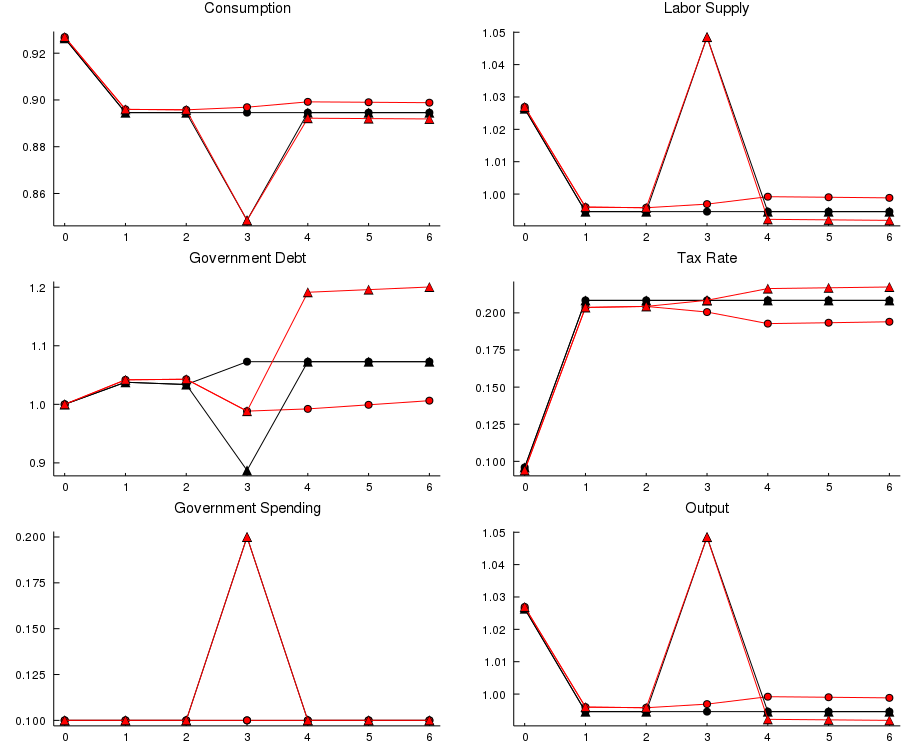

In [6]:
time_example = crra_utility(G=[0.1, 0.1, 0.1, 0.2, 0.1, 0.1],
                            Θ = ones(6)) # Θ can in principle be random

time_example.Π = [ 0.0 1.0 0.0 0.0 0.0 0.0;
                   0.0 0.0 1.0 0.0 0.0 0.0;
                   0.0 0.0 0.0 0.5 0.5 0.0;
                   0.0 0.0 0.0 0.0 0.0 1.0;
                   0.0 0.0 0.0 0.0 0.0 1.0;
                   0.0 0.0 0.0 0.0 0.0 1.0]

# Initialize μgrid for value function iteration
μgrid = range(-0.7, 0.01, length = 200)

time_example.transfers = true  # Government can use transfers
time_sequential = SequentialAllocation(time_example) # Solve sequential problem

time_bellman = RecursiveAllocation(time_example, μgrid)

sHist_h = [1, 2, 3, 4, 6, 6, 6]
sHist_l = [1, 2, 3, 5, 6, 6, 6]

sim_seq_h = simulate(time_sequential, 1., 1, 7, sHist_h)
sim_bel_h = simulate(time_bellman, 1., 1, 7, sHist_h)
sim_seq_l = simulate(time_sequential, 1., 1, 7, sHist_l)
sim_bel_l = simulate(time_bellman, 1., 1, 7, sHist_l)

using Plots
gr(fmt=:png);
titles = hcat("Consumption", "Labor Supply", "Government Debt",
              "Tax Rate", "Government Spending", "Output")
sim_seq_l_plot = hcat(sim_seq_l[1:3]..., sim_seq_l[4],
                      time_example.G[sHist_l],
                      time_example.Θ[sHist_l] .* sim_seq_l[2])
sim_bel_l_plot = hcat(sim_bel_l[1:3]..., sim_bel_l[5],
                      time_example.G[sHist_l],
                      time_example.Θ[sHist_l] .* sim_bel_l[2])
sim_seq_h_plot = hcat(sim_seq_h[1:3]..., sim_seq_h[4],
                      time_example.G[sHist_h],
                      time_example.Θ[sHist_h] .* sim_seq_h[2])
sim_bel_h_plot = hcat(sim_bel_h[1:3]..., sim_bel_h[5],
                      time_example.G[sHist_h],
                      time_example.Θ[sHist_h] .* sim_bel_h[2])
p = plot(size = (920, 750), layout =(3, 2),
 xaxis=(0:6), grid=false, titlefont=Plots.font("sans-serif", 10))
plot!(p, title = titles)
for i=1:6
    plot!(p[i], 0:6, sim_seq_l_plot[:, i], marker=:circle, color=:black, lab="")
    plot!(p[i], 0:6, sim_bel_l_plot[:, i], marker=:circle, color=:red, lab="")
    plot!(p[i], 0:6, sim_seq_h_plot[:, i], marker=:utriangle, color=:black, lab="")
    plot!(p[i], 0:6, sim_bel_h_plot[:, i], marker=:utriangle, color=:red, lab="")
end
p

How a Ramsey planner responds to  war depends on the structure of the asset market.

If it is able to trade state-contingent debt, then at time $ t=2 $

- the government purchases an Arrow security that pays off when $ g_3 = g_h $  
- the government sells an Arrow security that  pays off when $ g_3 = g_l $  
- These purchases are designed in such a way that regardless of whether or not there is a war at $ t=3 $, the government will begin  period $ t=4 $ with the *same* government debt  


This pattern facilities smoothing tax rates across  states

The government without state contingent debt cannot do this

Instead, it must enter   time $ t=3 $ with the same level of debt falling due whether there is peace or war at $ t=3 $

It responds to this constraint by smoothing tax rates across time

To finance a war it raises taxes and issues more debt

To service the additional debt burden, it raises taxes in all future periods

The absence of state contingent debt leads to an important difference in the
optimal tax policy

When the Ramsey planner has access to state contingent debt, the optimal tax
policy is history independent

- the tax rate is a function  of the current level of government spending only,
  given the Lagrange multiplier on the implementability constraint  


Without state contingent debt, the optimal tax rate is history dependent

- A war at time $ t=3 $ causes a permanent increase in the tax rate  

#### Perpetual War Alert

History dependence occurs more dramatically in a case in which the government
perpetually faces the prospect  of war

This case was studied in the final example of the lecture on
[optimal taxation with state-contingent debt](https://lectures.quantecon.org/jl/opt_tax_recur.html)

There, each period the government faces a constant probability, $ 0.5 $, of war

In addition, this example features the following preferences

$$
u(c,n) = \log(c) + 0.69 \log(1-n)
$$

In accordance, we will re-define our utility function

In [7]:
function log_utility(;β = 0.9,
                    ψ = 0.69,
                    Π = 0.5 * ones(2, 2),
                    G = [0.1, 0.2],
                    Θ = ones(2),
                    transfers = false)
    # Derivatives of utility function
    U(c,n) = log(c) + ψ * log(1 - n)
    Uc(c,n) = 1 ./ c
    Ucc(c,n) = -c.^(-2.0)
    Un(c,n) = -ψ ./ (1.0 .- n)
    Unn(c,n) = -ψ ./ (1.0 .- n).^2.0
    n_less_than_one = true
    return Model(β, Π, G, Θ, transfers,
                U, Uc, Ucc, Un, Unn, n_less_than_one)
end

log_utility (generic function with 1 method)

With these preferences, Ramsey tax rates will vary even in the Lucas-Stokey
model with state-contingent debt

The figure below plots optimal tax policies for both the economy with
state contingent debt (circles) and the economy with only a risk-free bond
(triangles)

diff = 0.0007972378476372139


diff = 0.0006423560333504441


diff = 0.0005517441622530832


diff = 0.00048553930013351857


diff = 0.0004226590836939342


diff = 0.00037550672316976404


diff = 0.0003294032122270672


diff = 0.00029337232321718974


diff = 0.00025856795048240623


diff = 0.00023042624865279873


diff = 0.0002031214087191915


diff = 0.00018115282833643646


diff = 0.00016034374751970243


diff = 0.00014294960573402432


diff = 0.0001267581715890033


diff = 0.00011295205489914281


diff = 0.00010030878977062024


diff = 8.934103186095062e-5


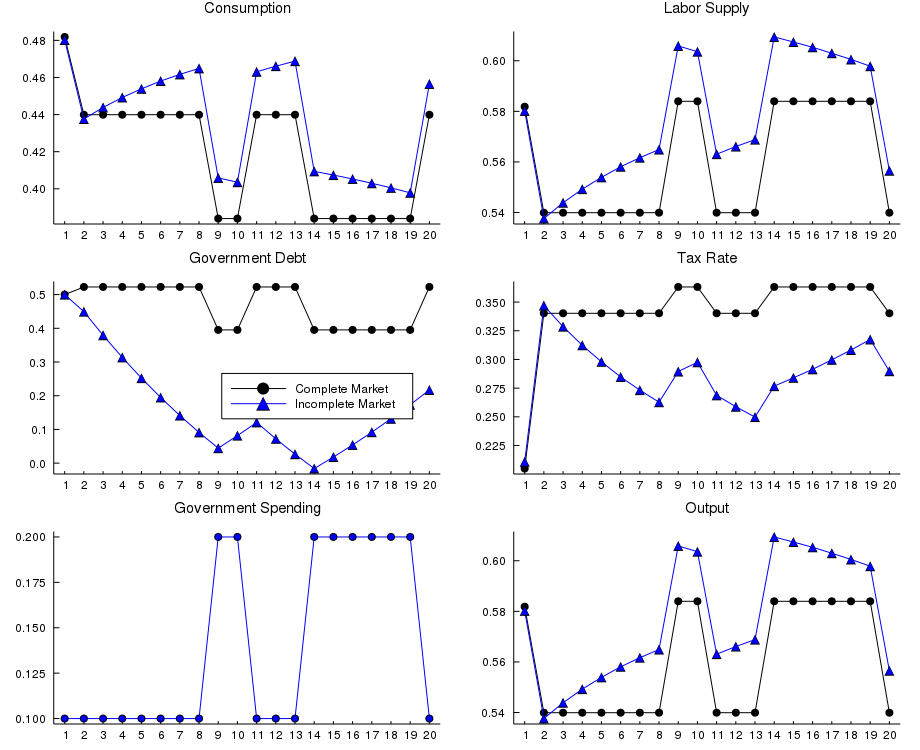

In [8]:
log_example = log_utility()

log_example.transfers = true                             # Government can use transfers
log_sequential = SequentialAllocation(log_example)       # Solve sequential problem
log_bellman = RecursiveAllocation(log_example, μgrid)    # Solve recursive problem

T = 20
sHist = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1]

#simulate
sim_seq = simulate(log_sequential, 0.5, 1, T, sHist)
sim_bel = simulate(log_bellman, 0.5, 1, T, sHist)

sim_seq_plot = hcat(sim_seq[1:3]...,
            sim_seq[4], log_example.G[sHist], log_example.Θ[sHist] .* sim_seq[2])
sim_bel_plot = hcat(sim_bel[1:3]...,
            sim_bel[5], log_example.G[sHist], log_example.Θ[sHist] .* sim_bel[2])

#plot policies
p = plot(size = (920, 750), layout = grid(3, 2),
         xaxis=(0:T), grid=false, titlefont=Plots.font("sans-serif", 10))
labels = fill(("", ""), 6)
labels[3] = ("Complete Market", "Incomplete Market")
plot!(p, title = titles)
for i = vcat(collect(1:4), 6)
    plot!(p[i], sim_seq_plot[:, i], marker=:circle, color=:black, lab=labels[i][1])
    plot!(p[i], sim_bel_plot[:, i], marker=:utriangle, color=:blue, lab=labels[i][2],
          legend=:bottomright)
end
plot!(p[5], sim_seq_plot[:, 5], marker=:circle, color=:blue, lab="")

When the government experiences a prolonged period of peace, it is able to reduce
government debt and set permanently lower tax rates

However, the government  finances a long war by borrowing and raising taxes

This results in a drift away from  policies with state contingent debt that
depends on the history of shocks

This is even more evident in the following figure that plots the evolution of
the two policies over 200 periods

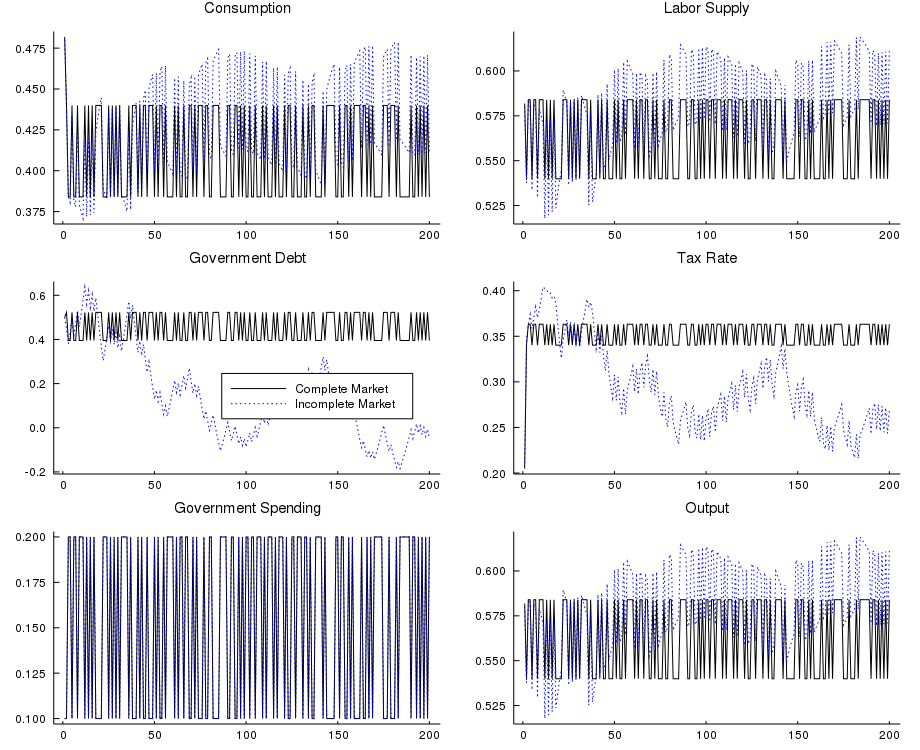

In [9]:
T_long = 200
sim_seq_long = simulate(log_sequential, 0.5, 1, T_long)
sHist_long = sim_seq_long[end-2]
sim_bel_long = simulate(log_bellman, 0.5, 1, T_long, sHist_long)
sim_seq_long_plot = hcat(sim_seq_long[1:4]...,
             log_example.G[sHist_long], log_example.Θ[sHist_long] .* sim_seq_long[2])
sim_bel_long_plot = hcat(sim_bel_long[1:3]..., sim_bel_long[5],
             log_example.G[sHist_long], log_example.Θ[sHist_long] .* sim_bel_long[2])

p = plot(size = (920, 750), layout = (3, 2), xaxis=(0:50:T_long), grid=false,
         titlefont=Plots.font("sans-serif", 10))
plot!(p, title = titles)
for i = 1:6
    plot!(p[i], sim_seq_long_plot[:, i], color=:black, linestyle=:solid, lab=labels[i][1])
    plot!(p[i], sim_bel_long_plot[:, i], color=:blue, linestyle=:dot, lab=labels[i][2],
          legend=:bottomright)
end
p

**Footnotes**

<p><a id=fn-a href=#fn-a-link><strong>[1]</strong></a> In an allocation that solves the Ramsey problem and that levies distorting
taxes on labor, why would the government ever want to hand revenues back
to the private sector? It would not in an economy with state-contingent debt, since
any such allocation could be improved by lowering distortionary taxes
rather than handing out lump-sum transfers. But without state-contingent
debt  there can be circumstances when a government would like to make
lump-sum transfers to the private sector.

<p><a id=fn-b href=#fn-b-link><strong>[2]</strong></a> From the first-order conditions for the Ramsey
problem, there exists another realization $ \tilde s^t $ with
the same history up until the previous period, i.e., $ \tilde s^{t-1}=
s^{t-1} $, but where the multiplier on constraint [(11)](#equation-amss-46) takes  a positive value, so
$ \gamma_t(\tilde s^t)>0 $.